In [6]:
# Team Members
# Joed Quaye
# Ronald Chomnou
# Griffin Araujo

# impoting all the necessary libraries
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from urllib.request import urlopen
from urllib.error import HTTPError
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import html5lib
import lxml
from datetime import datetime 
from io import StringIO




In [ ]:
pip install lxml

In [9]:
# Step 1: Use webdriver to get the URL

url = "https://www.spaceweatherlive.com/en/solar-activity/top-50-solar-flares.html"
driver = webdriver.Safari()  
driver.get(url)
# extract text from page
page_content = driver.page_source
# using BeautifulSoup to read/parse the data
soup = BeautifulSoup(page_content, 'html.parser')
# prettify to view the content and find the appropriate table
soup.prettify()
# identifying the appropriate table 
table = soup.find('table')

# using StringIO to convert HTML to file-like object
table_str = str(table)
table_string = StringIO(table_str)

# using Pandas to read the HTML file into a DataFrame
dataframe = pd.read_html(table_string)[0]
# setting names for the columns in the dataframe
dataframe.columns = ['rank', 'x_class', 'date', 'region', 'start_time', 'max_time', 'end_time', 'movie']

# STEP 2

# dropping the last column
dataframe = dataframe.iloc[:, :-1]
# print(dataframe)
# combining date and time into three datetime columns
for index, row in dataframe.iterrows():
    date = row["date"]
    start = row["start_time"]
    end = row["end_time"]
    max = row["max_time"]

    # combining them into objects (new columns)
    start_datetime = datetime.strptime(f"{date} {start}", "%Y/%m/%d %H:%M")
    max_datetime = datetime.strptime(f"{date} {max}", "%Y/%m/%d %H:%M")
    end_datetime = datetime.strptime(f"{date} {end}", "%Y/%m/%d %H:%M")

    # now updating the values in the dataframe
    dataframe.at[index, 'start_datetime'] = start_datetime
    dataframe.at[index, 'end_datetime'] = end_datetime
    dataframe.at[index, 'max_endtime'] = max_datetime

# dropping the original columns from the list 
dataframe = dataframe.drop(['date', 'start_time', 'max_time', 'end_time'], axis=1)

# somehow above process misaligns number of columns so dropping one again
dataframe = dataframe.iloc[:, :-1]
print(dataframe)

# closing the webdriver
driver.quit()

# at this point, the data looks slightly different than in the example but we should be good 


    rank  x_class  region      start_datetime        end_datetime
0      1     X40+     486 2003-11-04 19:29:00 2003-11-04 20:06:00
1      2  X28.57+    9393 2001-04-02 21:32:00 2001-04-02 22:03:00
2      3  X24.57+     486 2003-10-28 09:51:00 2003-10-28 11:24:00
3      4  X24.42+     808 2005-09-07 17:17:00 2005-09-07 18:03:00
4      5  X20.67+    9415 2001-04-15 13:19:00 2001-04-15 13:55:00
5      6   X14.36     486 2003-10-29 20:37:00 2003-10-29 21:01:00
6      7   X13.37    2673 2017-09-06 11:53:00 2017-09-06 12:10:00
7      8   X12.97    8100 1997-11-06 11:49:00 1997-11-06 12:01:00
8      9   X12.95     930 2006-12-05 10:18:00 2006-12-05 10:45:00
9     10   X11.96     486 2003-11-02 17:03:00 2003-11-02 17:39:00
10    11   X11.88    2673 2017-09-10 15:35:00 2017-09-10 16:31:00
11    12   X10.18     720 2005-01-20 06:36:00 2005-01-20 07:26:00
12    13    X9.96    1263 2011-08-09 07:48:00 2011-08-09 08:08:00
13    14     X9.4     930 2006-12-06 18:29:00 2006-12-06 19:00:00
14    15  

In [10]:
# STEP 3 : Scraping the NASA data

import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from datetime import datetime
from io import StringIO
import html5lib
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait

# Set up the WebDriver
url = "http://cdaw.gsfc.nasa.gov/CME_list/radio/waves_type2.html"
driver = webdriver.Safari()
driver.get(url)

# Wait for the page to load
wait = WebDriverWait(driver, 10)
wait.until(EC.presence_of_element_located((By.TAG_NAME, 'body')))
page_content = driver.page_source

# Use BeautifulSoup to parse the HTML
soup = BeautifulSoup(page_content, 'html.parser')

# Find the appropriate table within the pre tag
table = soup.find('pre')
# Extract each row of data as a long string
rows = table.text.split('\n')


# Create a list to store dictionaries representing each row
data_list = []

# Process each row and extract data
for row in rows[11:493]:  # Skip the header and footer
    columns = row.split()
    start_date = columns[0]
    year = start_date.split('/')[0]  # Extract the year from the start_date
    end_date = f"{year}/{columns[2]}"  # Add the year to the end_date
    cme_date = f"{year}/{columns[9]}"  # Add the year to the cme_date
    flare_classification = columns[8]
    # Replace '----' with NaN in the flare_classification column
    if flare_classification == '----':
        flare_classification = 'NaN'
    data_dict = {
        'start_date': start_date,
        'start_time': columns[1],
        'end_date': end_date,
        'end_time': columns[3],
        'start_frequency': columns[4],
        'end_frequency': columns[5],
        'flare_location': columns[6],
        'flare_region': columns[7],
        'flare_classification': flare_classification,
        'cme_date': cme_date,
        'cme_time': columns[10],
        'cme_angle': columns[11],
        'cme_width': columns[12],
        'cme_speed': columns[13],
        'halo_lower_bound': columns[14]
    }
    data_list.append(data_dict)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data_list)

# Set the index to start from 1
df.index = df.index + 1

# Display the DataFrame
print(df)

    
# Close the webdriver
driver.quit()    


     start_date start_time    end_date end_time start_frequency end_frequency  \
1    1997/01/20      08:56  1997/01/20    09:02           14000         12000   
2    1997/04/01      14:00  1997/04/01    14:15            8000          4000   
3    1997/04/07      14:30  1997/04/07    17:30           11000          1000   
4    1997/05/12      05:15  1997/05/14    16:00           12000            80   
5    1997/05/21      20:20  1997/05/21    22:00            5000           500   
..          ...        ...         ...      ...             ...           ...   
478  2014/09/01      11:12  2014/09/01    20:05           16000           150   
479  2014/09/09      00:05  2014/09/09    13:00           11000           100   
480  2014/09/10      17:45  2014/09/11    12:00           14000           100   
481  2014/09/20      05:10  2014/09/20    05:30           14000          9700   
482  2014/09/22      06:13  2014/09/22    06:50           16000          4900   

    flare_location flare_re

In [12]:
# Step 4
# Drop the first row
df = df.drop(1)

# Reset the index starting from 0
df.reset_index(drop=True, inplace=True)

# Create a new column 'cpa_width_speed' by combining the data
df['cpa_width_speed'] = df.apply(lambda row: f"{'NaN' if row['cme_angle'] == 'Halo' else row['cme_angle']} {row['cme_width']} {row['cme_speed']}", axis=1)

# Drop the columns 'cme_angle', 'cme_width', and 'cme_speed'
df = df.drop(['cme_angle', 'cme_width', 'cme_speed'], axis=1)

# Set up missing values
missing_values = ['----', '-----', '------']
df = df.replace(missing_values, 'NaN')

# Recode 'is_halo' column
df['is_halo'] = df['cpa_width_speed'].apply(lambda x: 'True' if 'NaN' in x else 'False')
# Replace 'Halo' entries in the cpa_width_speed column with 'NaN'
df['cpa_width_speed'] = df['cpa_width_speed'].replace('Halo', 'NaN')

# Recode 'width_lower_bound' column
df['width_lower_bound'] = df['cpa_width_speed'].apply(lambda x: isinstance(x, str) and x.startswith('>'))
# Remove any non-numeric part of the cpa_width_speed column
df['cpa_width_speed'] = df['cpa_width_speed'].apply(lambda x: ' '.join(filter(None, x.split())))

# Combine date and time columns
df['start_datetime'] = pd.to_datetime(df['start_date'] + ' ' + df['start_time'])
df['end_datetime'] = pd.to_datetime(df['end_date'] + ' ' + df['end_time'], errors='coerce')
# Combine 'start_date' and 'cme_time' for 'cme_datetime'
df['cme_datetime'] = pd.to_datetime(df['start_date'] + ' ' + df['cme_time'], errors='coerce')

# Rename columns
df = df.rename(columns={'flare_classification': 'importance', 'halo_lower_bound': 'plot'})
# Rearrange columns in the DataFrame
df = df[['start_datetime', 'end_datetime', 'start_frequency', 'end_frequency', 'flare_location',
         'flare_region', 'importance', 'cme_datetime', 'cpa_width_speed',
         'plot', 'is_halo', 'width_lower_bound']]

# Convert DataFrame to a formatted string and print
table_str = df.to_string(index=True, col_space=5, na_rep='NaN')
print(table_str)


           start_datetime        end_datetime start_frequency end_frequency flare_location flare_region importance        cme_datetime cpa_width_speed  plot is_halo  width_lower_bound
0     1997-04-01 14:00:00 1997-04-01 14:15:00            8000          4000         S25E16         8026       M1.3 1997-04-01 15:18:00       74 79 312  PHTX   False              False
1     1997-04-07 14:30:00 1997-04-07 17:30:00           11000          1000         S28E19         8027       C6.8 1997-04-07 14:27:00     NaN 360 878  PHTX    True              False
2     1997-05-12 05:15:00 1997-05-14 16:00:00           12000            80         N21W08         8038       C1.3 1997-05-12 05:30:00     NaN 360 464  PHTX    True              False
3     1997-05-21 20:20:00 1997-05-21 22:00:00            5000           500         N05W12         8040       M1.3 1997-05-21 21:00:00     263 165 296  PHTX   False              False
4     1997-09-23 21:53:00 1997-09-23 22:16:00            6000          2000     

In [13]:
# Question 1
# You can achieve a pretty good replication of the NASA data
# and the spaceweatherlive data

# Sort the NASA data by flare classification in descending order
df_nasa_sorted = df.sort_values(by='start_datetime', ascending=False)

# Select the top 50 solar flares from NASA data
top_50_nasa = df_nasa_sorted.head(50)

# Compare the top 50 NASA flares with SpaceWeatherLive data
matched_events = pd.merge(top_50_nasa, dataframe, how='inner', on=['start_datetime', 'end_datetime'])

# Print events
print(matched_events)

Empty DataFrame
Columns: [start_datetime, end_datetime, start_frequency, end_frequency, flare_location, flare_region, importance, cme_datetime, cpa_width_speed, plot, is_halo, width_lower_bound, rank, x_class, region]
Index: []


In [14]:
# Question 2
# TO find the best matching row in the NASA data for the top 50 solar flares
# in the spaceweatherlive data, there is a set of criteria to determine which
# is the best. That criteria is start time, end time, and importance
def find_matches(dataframe, df):
    matches = []

    for _, swl_row in dataframe.iterrows():
        # Define matching criteria here
        matching_criteria = ['start_datetime', 'end_datetime']

        # Find the best match based on the defined criteria
        best_match = df.loc[
            (df['start_datetime'] == swl_row['start_datetime']) &
            (df['end_datetime'] == swl_row['end_datetime'])
            ]

        if not best_match.empty:
            matches.append(best_match)

    return pd.concat(matches, ignore_index=True)



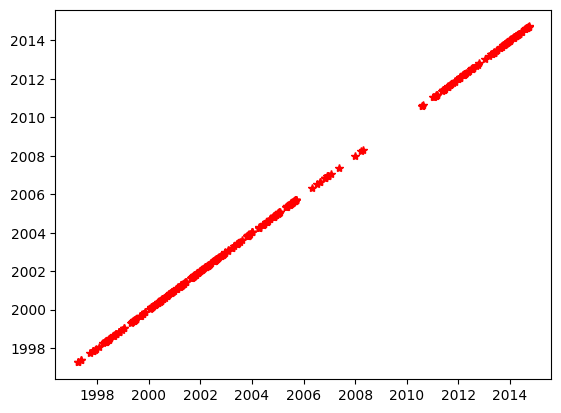

In [15]:
# Question 3
# importing necessary library
import matplotlib.pyplot as plot

# sorting values by the datetime and subsequently plotting it
df.sort_values(by='start_datetime', ascending=True)
plot.plot(df['start_datetime'], df['end_datetime'], '*', color="red")
plot.show()